# Data Challenge 2 - Reorder Sentences

Submitted by: Siqi Liu

Student ID: 20428295

WatIAm: sq2liu

### Scripts - Config

In [1]:
args = {
    'data_dir': '/kaggle/input/stat946winter2021dc2/',
    'labeled_filename': 'train.pkl',
    'pred_filename': 'test.pkl',
    'seed': 647,
    'val_size': 0.1,
    'model_type': 'bert-base-uncased',
    'do_lower_case': True,
    'max_seq_length_fsent': 128,
    'max_seq_length_pair': 256,
    'target_ratio': 0.5,
    'num_train_samples_fsent': int(1e4),
    'num_train_samples_pair': int(5e4),
    'num_val_samples_fsent': int(1e3),
    'num_val_samples_pair': int(1e3),
    'num_epochs_fsent': 5,
    'num_epochs_pair': 5,
    'train_batch_size_fsent': 16,
    'train_batch_size_pair': 16,
    'val_batch_size_fsent': 16,
    'val_batch_size_pair': 16,
    'lr_fsent': 5e-5,
    'lr_pair': 5e-5,
    'adam_eps_fsent': 1e-8,
    'adam_eps_pair': 1e-8,
    'warmup_steps_fsent': 0,
    'warmup_steps_pair': 0
}

### Scripts - Utilities

In [2]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt


def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Current device: {:s}".format(device.type))
    return device


def set_seed():
    seed = args['seed']
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def plot_statistics(measure, values):
    fig = plt.figure(figsize=(20, 10))
    plt.title("train/validation {}".format(measure))
    plt.plot(values['train'], label='train')
    plt.plot(values['val'], label='val')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel(measure)
    plt.legend(loc='best')

### Scripts - Data

In [3]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler, WeightedRandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from itertools import permutations
from collections import namedtuple, Counter
from math import floor
import torch
import pickle


def load_dataset(file):
    dataset = pickle.load(open(file, 'rb'))
    print("{:s} loaded. Size: {:d}".format(file, len(dataset)))
    return dataset


def load_labeled_dataset():
    return load_dataset(args['data_dir'] + args['labeled_filename'])


def load_pred_dataset():
    return load_dataset(args['data_dir'] + args['pred_filename'])


def split_labeled_set(dataset, val_size=0.2):
    set_seed()
    train_set, val_set = train_test_split(dataset, test_size=val_size)
    print("train_set size: {:d}\nval_set size: {:d}".format(
        len(train_set), len(val_set)
    ))
    return train_set, val_set


def get_fsents(dataset):
    fsents = []
    for i, doc in enumerate(dataset):
        for j, text in enumerate(doc['sentences']):
            if doc['indexes'][j] == 0:
                fsents.append(text)
    return fsents


Sentence = namedtuple('Sentence', ('guid', 'text', 'index', 'label'))


def clean_text(text):
    return text


class FirstSentenceDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.sentences, self.labels = self._get_sentences(data)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def _get_sentences(self, data):
        sentences = []
        labels = []
        for i, doc in enumerate(data):
            for j, text in enumerate(doc['sentences']):
                guid = '{:d}-{:d}'.format(i, j)
                if 'indexes' in doc:
                    index = doc['indexes'][j]
                else:
                    index = -1
                label = 1 if index == 0 else 0
                labels.append(label)
                sentences.append(Sentence(guid, text, index, label))
        print("Dataset loaded. Size: {:d}".format(len(sentences)))
        return sentences, labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]
        cleaned_text = clean_text(sentence.text)

        encoding = self.tokenizer.encode_plus(
            cleaned_text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,  # single sentence, do not need
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'guid': sentence.guid,
            'text': sentence.text,
            'cleaned_text': cleaned_text,
            'index': sentence.index,
            'label': torch.LongTensor([sentence.label]),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }


SentencePair = namedtuple('SentencePair',
                          ('guid', 'text_a', 'text_b',
                           'index_a', 'index_b', 'label')
                          )


class SentencePairDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.sentence_pairs, self.labels = self._get_sentence_pairs(data)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def _get_sentence_pairs(self, data):
        sentence_pairs = []
        labels = []
        for i, doc in enumerate(data):
            # all pairwise permutations of the sentences
            perms = list(permutations(enumerate(doc['sentences']), 2))
            for (a, text_a), (b, text_b) in perms:
                guid = "{:d}-{:d}-{:d}".format(i, a, b)
                if 'indexes' in doc:
                    index_a = doc['indexes'][a]
                    index_b = doc['indexes'][b]
                    label = 1 if (index_b - index_a) == 1 else 0
                else:
                    index_a, index_b, label = -1, -1, -1
                labels.append(label)
                sentence_pairs.append(SentencePair(
                    guid, text_a, text_b, index_a, index_b, label
                ))
        print("Dataset loaded. Size: {:d}".format(len(sentence_pairs)))
        return sentence_pairs, labels

    def __len__(self):
        return len(self.sentence_pairs)

    def __getitem__(self, index):
        sentence_pair = self.sentence_pairs[index]
        cleaned_text_a = clean_text(sentence_pair.text_a)
        cleaned_text_b = clean_text(sentence_pair.text_b)

        encoding = self.tokenizer.encode_plus(
            cleaned_text_a,
            cleaned_text_b,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        if len(encoding['input_ids']) > self.max_length:
            cleaned_text_a, cleaned_text_b = truncate_texts(
                cleaned_text_a,
                cleaned_text_b,
                self.tokenizer,
                self.max_length
            )
            encoding = self.tokenizer.encode_plus(
                cleaned_text_a,
                cleaned_text_b,
                add_special_tokens=True,
                max_length=self.max_length,
                return_token_type_ids=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            assert len(encoding['input_ids']) <= self.max_length

        return {
            'guid': sentence_pair.guid,
            'text_a': sentence_pair.text_a,
            'text_b': sentence_pair.text_b,
            'cleaned_text_a': cleaned_text_a,
            'cleaned_text_b': cleaned_text_b,
            'index_a': sentence_pair.index_a,
            'index_b': sentence_pair.index_b,
            'label': torch.LongTensor([sentence_pair.label]),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }


def truncate_texts(text_a, text_b, tokenizer, max_length):
    # exclude [CLS] and [SEP]
    encoding_a = tokenizer.encode(text_a)
    length_a = len(encoding_a) - 2
    encoding_b = tokenizer.encode(text_b)
    length_b = len(encoding_b) - 2
    # exclude [CLS] and [SEP] x 2
    max_length_each = floor((max_length - 3) / 2)
    if length_a < max_length_each:
        # a is okay, truncate b
        text_b = tokenizer.decode(
            encoding_b[1:max_length - 3 - length_a + 1]
        )
    elif length_b < max_length_each:
        # b is okay, truncate a
        text_a = tokenizer.decode(
            encoding_a[1:max_length - 3 - length_b + 1]
        )
    else:
        # truncate both
        text_a = tokenizer.decode(
            encoding_a[1:max_length_each + 1]
        )
        text_b = tokenizer.decode(
            encoding_b[1:max_length_each + 1]
        )
    return text_a, text_b


def get_weights_for_balanced_classes(dataset, target_ratio=0.3):
    labels = dataset.labels
    label_counts = Counter(labels)
    num_ones = label_counts[1]
    num_zeros = label_counts[0]
    weight_one = target_ratio / (1 - target_ratio) * (num_zeros / num_ones)
    print("Weight for Ones: {:.4f}".format(weight_one))
    return [weight_one if label == 1 else 1 for label in labels], weight_one


### Scripts - Model

In [4]:
from transformers import AdamW, BertForSequenceClassification, BertTokenizer, get_linear_schedule_with_warmup
import torch
import time
import copy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.stats import spearmanr


def load_model_fsent():
    return BertForSequenceClassification.from_pretrained(
        args['model_type'],
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )


def load_model_pair():
    return BertForSequenceClassification.from_pretrained(
        args['model_type'],
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )


def load_tokenizer():
    return BertTokenizer.from_pretrained(
        args['model_type'],
        do_lower_case=args['do_lower_case']
    )


def get_optimizer_fsent(model):
    return AdamW(
        model.parameters(),
        lr=args['lr_fsent'],
        eps=args['adam_eps_fsent']
    )

def get_optimizer_pair(model):
    return AdamW(
        model.parameters(),
        lr=args['lr_pair'],
        eps=args['adam_eps_pair']
    )


def get_scheduler_fsent(optimizer, num_training_steps):
    return get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=args['warmup_steps_fsent'],
        num_training_steps=num_training_steps
    )

def get_scheduler_pair(optimizer, num_training_steps):
    return get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=args['warmup_steps_pair'],
        num_training_steps=num_training_steps
    )


def train(model, model_name, dataloaders, dataset_sizes, optimizer, scheduler, num_epochs):
    # set seed
    set_seed()
    
    # starting time
    since = time.time()

    # store model that yields the highest accuracy in the validation set
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    # keep track of the statistics
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    # iterate through each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            # loss and number of correct predictions
            running_loss = 0.0
            running_corrects = 0
            running_data = 0

            # iterate over each batch
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for batch in tepoch:
                    # Unravel inputs
                    input_ids = batch['input_ids'].to(device)
                    if 'token_type_ids' in batch:
                        # pairwise prediction
                        token_type_ids = batch['token_type_ids'].to(device)
                    else:
                        # first sentence prediction
                        token_type_ids = None
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    # reset the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(
                            input_ids=input_ids,
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask,
                            labels=labels
                        )
                        loss = outputs.loss
                        logits = outputs.logits
                        preds = torch.argmax(logits, axis=1)

                        # backward only if in training
                        if phase == 'train':
                            loss.backward()
                            torch.nn.utils.clip_grad_norm_(
                                model.parameters(),
                                1.0
                            )
                            optimizer.step()
                            scheduler.step()

                    # add to statistics
                    running_loss += loss.item() * len(labels)
                    running_corrects += torch.sum(
                        preds == labels.data.flatten()
                    )
                    running_data += len(labels)

                    # update progress bar
                    tepoch.set_postfix(
                        loss=(running_loss / running_data),
                        accuracy=(running_corrects.item() / running_data)
                    )
                    time.sleep(0.1)

            # compute loss and accuracy at epoch level
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            print('{} Loss: {:.4f}; Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc
            ))

            # deep copy the model when epoch accuracy (on validation set) is the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
                torch.save(model, f'{model_name}_model_checkpoint.pt')
                print('Best model so far! Saved checkpoint.')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best Val Acc: {:4f} at Epoch: {:d}'.format(best_acc, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_epoch, losses, accuracies

def predict_submission(docs, device, model_fsent, model_pair, tokenizer):
    preds = []
    with tqdm(total=len(docs)) as pbar:
        for i, doc in enumerate(docs):
            pred_index = predict(doc, device, model_fsent,
                                 model_pair, tokenizer)
            d = {
                'ID': doc['ID'],
                'index1': pred_index[0],
                'index2': pred_index[1],
                'index3': pred_index[2],
                'index4': pred_index[3],
                'index5': pred_index[4],
                'index6': pred_index[5],
            }
            preds.append(d)
            pbar.update(1)
            time.sleep(0.1)
    return pd.DataFrame(preds)

def evaluate(docs, device, model_fsent, model_pair, tokenizer, num_samples=100):
    set_seed()
    sample_docs = random.sample(docs, num_samples)
    running_corr = 0
    with tqdm(total=num_samples) as pbar:
        for i, doc in enumerate(sample_docs):
            gold_index = doc['indexes']
            pred_index = predict(doc, device, model_fsent,
                                 model_pair, tokenizer)
            corr, _ = spearmanr(gold_index, pred_index)
            running_corr += corr
            pbar.update(1)
            pbar.set_postfix(
                spearman=(running_corr / (i + 1))
            )
            time.sleep(0.1)
    return running_corr / num_samples

def predict(doc, device, model_fsent, model_pair, tokenizer):
    # predict first sentence position
    fsent_pos = predict_fsent_pos(doc, device, model_fsent, tokenizer)
    # predict sentence pairs logits
    pair_logits = predict_pair_logits(doc, device, model_pair, tokenizer)
    # construct graph based on predictions
    num_vertices = len(doc['sentences'])
    graph = make_graph(num_vertices, pair_logits)
    # sort and get the order
    order, weight = graph.max_flow(fsent_pos)
    # get indices
    index = [-1] * num_vertices
    for p, o in enumerate(order):
        index[o] = p
    return index



def predict_fsent_pos(doc, device, model, tokenizer):
    fsent_pos, max_logit = None, float('-inf')
    for i, text in enumerate(doc['sentences']):
        cleaned_text = clean_text(text)
        encoding = tokenizer.encode_plus(
            cleaned_text,
            add_special_tokens=True,
            max_length=args['max_seq_length_fsent'],
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        outputs = model(
            input_ids=encoding.input_ids.to(device),
            token_type_ids=None,
            attention_mask=encoding.attention_mask.to(device)
        )
        logits = outputs.logits.detach().cpu().numpy().squeeze()
        pred = np.argmax(logits)
        if (pred == 1) and (logits[1] > max_logit):
            fsent_pos = i
            max_logit = logits[1]
    return fsent_pos


def predict_pair_logits(doc, device, model, tokenizer):
    pair_logits = []
    perms = list(permutations(enumerate(doc['sentences']), 2))
    for (a, text_a), (b, text_b) in perms:
        cleaned_text_a = clean_text(text_a)
        cleaned_text_b = clean_text(text_b)
        encoding = tokenizer.encode_plus(
            cleaned_text_a,
            cleaned_text_b,
            add_special_tokens=True,
            max_length=args['max_seq_length_pair'],
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        if len(encoding['input_ids']) > args['max_seq_length_pair']:
            cleaned_text_a, cleaned_text_b = truncate_texts(
                cleaned_text_a,
                cleaned_text_b,
                tokenizer,
                args['max_seq_length_pair']
            )
            encoding = tokenizer.encode_plus(
                cleaned_text_a,
                cleaned_text_b,
                add_special_tokens=True,
                max_length=args['max_seq_length_pair'],
                return_token_type_ids=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            assert len(encoding['input_ids']) <= args['max_seq_length_pair']
        outputs = model(
            input_ids=encoding.input_ids.to(device),
            token_type_ids=encoding.token_type_ids.to(device),
            attention_mask=encoding.attention_mask.to(device)
        )
        logits = outputs.logits.detach().cpu().numpy().squeeze()
        pair_logits.append((a, b, logits))
    return pair_logits


def make_graph(num_vertices, pair_logits):
    graph = Graph(num_vertices)
    # add edge weights
    for a, b, [logit0, logit1] in pair_logits:
        graph.addEdge(a, b, logit1)
    return graph

### Scripts - Graph

In [5]:
from itertools import permutations


class Graph:
    def __init__(self, num_vertices):
        self.num_vertices = num_vertices
        self.graph = [[None for _ in range(num_vertices)]
                      for _ in range(num_vertices)]

    def addEdge(self, u, v, w):
        self.graph[u][v] = w

    def max_flow(self, start):
        if start:
            candidate_paths = [[start] + list(p) for p in list(
                permutations(list(range(0, start)) + list(range(start + 1, self.num_vertices)), self.num_vertices - 1))]
        else:
            candidate_paths = [list(p) for p in list(
                permutations(list(range(0, self.num_vertices)), self.num_vertices))]
        best_path, max_weight = None, float('-inf')
        for path in candidate_paths:
            weight = self.get_path_weight(path)
            if weight > max_weight:
                best_path = path
                max_weight = weight
        return best_path, max_weight

    def get_path_weight(self, path):
        weight = 0
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            assert self.graph[u][v] != None
            weight += self.graph[u][v]
        return weight

### Set-up

In [6]:
device = get_device()

Current device: cuda


### Load Data

In [7]:
labeled_set = load_labeled_dataset()
pred_set = load_pred_dataset()

/kaggle/input/stat946winter2021dc2/train.pkl loaded. Size: 590226
/kaggle/input/stat946winter2021dc2/test.pkl loaded. Size: 2000


### Load Models and Tokenizer

In [8]:
model_fsent = load_model_fsent()
model_fsent.to(device)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [9]:
model_pair = load_model_pair()
model_pair.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [10]:
tokenizer = load_tokenizer()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

### Split Labaled Data

In [11]:
train_set, val_set = split_labeled_set(labeled_set, val_size=args['val_size'])

train_set size: 531203
val_set size: 59023


### First Sentence Datasets, Sampler and DataLoaders

In [12]:
train_dataset_fsent = FirstSentenceDataset(train_set, tokenizer, args['max_seq_length_fsent'])
val_dataset_fsent = FirstSentenceDataset(val_set, tokenizer, args['max_seq_length_fsent'])

Dataset loaded. Size: 3187218
Dataset loaded. Size: 354138


In [13]:
train_weights_fsent, weight_one_fsent = get_weights_for_balanced_classes(
    train_dataset_fsent,
    target_ratio=args['target_ratio']
)

train_sampler_fsent = WeightedRandomSampler(
    weights=train_weights_fsent,
    num_samples=args['num_train_samples_fsent'],
    replacement=False
)

val_sampler_fsent = RandomSampler(
    data_source=val_dataset_fsent,
    num_samples=args['num_val_samples_fsent'],
    replacement=True
)

Weight for Ones: 5.0000


In [14]:
train_dataloader_fsent = DataLoader(
    train_dataset_fsent,
    sampler=train_sampler_fsent,
    batch_size=args['train_batch_size_fsent']
)

val_dataloader_fsent = DataLoader(
    val_dataset_fsent,
    sampler=val_sampler_fsent,
    batch_size=args['val_batch_size_fsent']
)

dataloaders_fsent = {
    'train' : train_dataloader_fsent,
    'val' : val_dataloader_fsent
}

In [15]:
dataset_sizes_fsent = {
    'train' : args['num_train_samples_fsent'],
    'val' : args['num_val_samples_fsent'],
}

### First Sentence Optimizer and Scheduler

In [16]:
optimizer_fsent = get_optimizer_fsent(model_fsent)

In [17]:
scheduler_fsent = get_scheduler_fsent(
    optimizer_fsent,
    len(train_dataloader_fsent) * args['num_epochs_fsent']
)

In [18]:
model_fsent, best_epoch_fsent, losses_fsent, accuracies_fsent = train(
    model=model_fsent,
    model_name='fsent',
    dataloaders=dataloaders_fsent,
    dataset_sizes=dataset_sizes_fsent,
    optimizer=optimizer_fsent,
    scheduler=scheduler_fsent,
    num_epochs=args['num_epochs_fsent']
)

Epoch 0/4
----------


  0%|          | 0/625 [00:00<?, ?batch/s]

train Loss: 0.1445; Acc: 0.9562


  0%|          | 0/63 [00:00<?, ?batch/s]

val Loss: 0.1316; Acc: 0.9710
Best model so far! Saved checkpoint.

Epoch 1/4
----------


  0%|          | 0/625 [00:00<?, ?batch/s]

train Loss: 0.1086; Acc: 0.9697


  0%|          | 0/63 [00:00<?, ?batch/s]

val Loss: 0.1121; Acc: 0.9720
Best model so far! Saved checkpoint.

Epoch 2/4
----------


  0%|          | 0/625 [00:00<?, ?batch/s]

train Loss: 0.0960; Acc: 0.9716


  0%|          | 0/63 [00:00<?, ?batch/s]

val Loss: 0.0492; Acc: 0.9850
Best model so far! Saved checkpoint.

Epoch 3/4
----------


  0%|          | 0/625 [00:00<?, ?batch/s]

train Loss: 0.0796; Acc: 0.9771


  0%|          | 0/63 [00:00<?, ?batch/s]

val Loss: 0.0566; Acc: 0.9830

Epoch 4/4
----------


  0%|          | 0/625 [00:00<?, ?batch/s]

train Loss: 0.0819; Acc: 0.9757


  0%|          | 0/63 [00:00<?, ?batch/s]

val Loss: 0.0825; Acc: 0.9750

Training complete in 19m 7s
Best Val Acc: 0.985000 at Epoch: 2


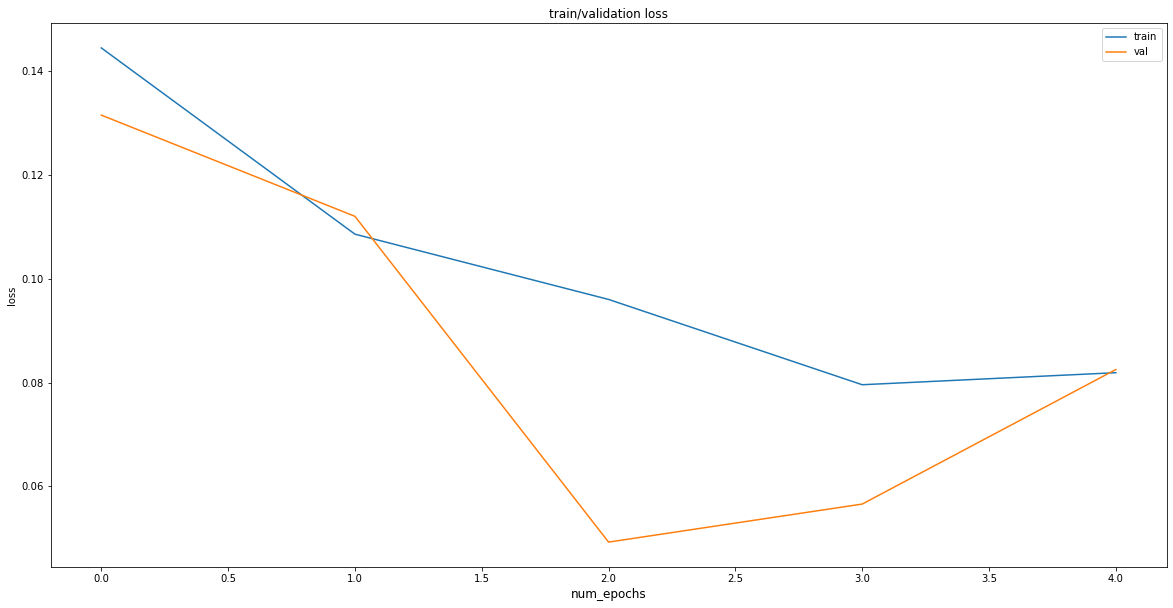

In [19]:
plot_statistics("loss", losses_fsent)

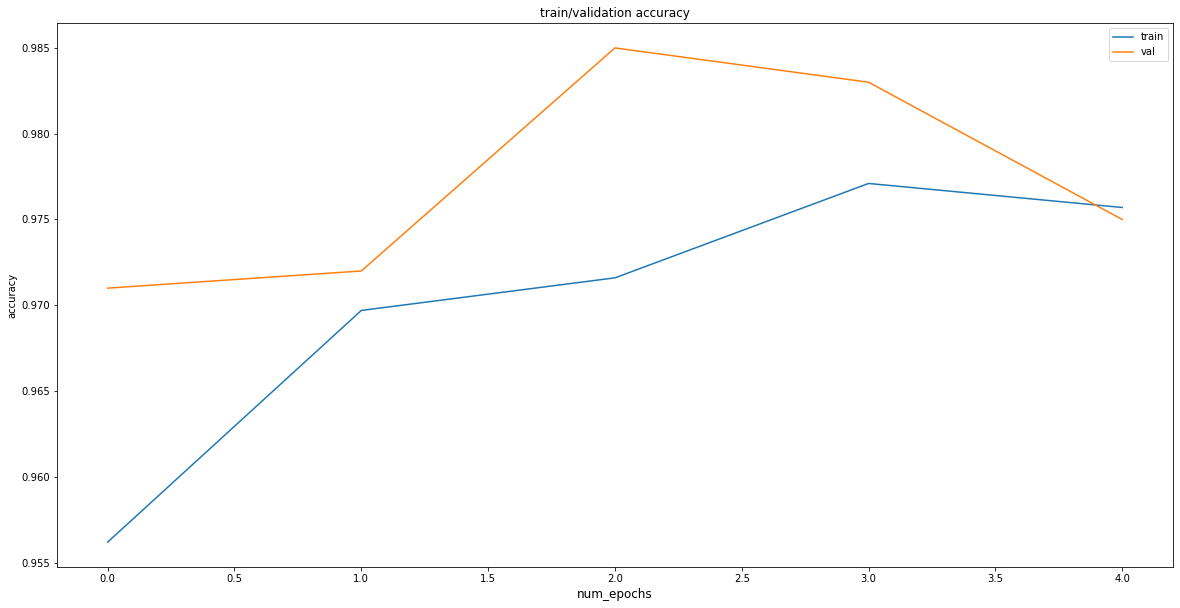

In [20]:
plot_statistics("accuracy", accuracies_fsent)

### Pair Datasets, Sampler and DataLoaders

In [21]:
train_dataset_pair = SentencePairDataset(train_set, tokenizer, args['max_seq_length_pair'])
val_dataset_pair = SentencePairDataset(val_set, tokenizer, args['max_seq_length_pair'])

Dataset loaded. Size: 15936090
Dataset loaded. Size: 1770690


In [22]:
train_weights_pair, weight_one_pair = get_weights_for_balanced_classes(
    train_dataset_pair,
    target_ratio=args['target_ratio']
)

train_sampler_pair = WeightedRandomSampler(
    weights=train_weights_pair,
    num_samples=args['num_train_samples_pair'],
    replacement=False
)

val_sampler_pair = RandomSampler(
    data_source=val_dataset_pair,
    num_samples=args['num_val_samples_pair'],
    replacement=True
)

Weight for Ones: 5.0000


In [23]:
train_dataloader_pair = DataLoader(
    train_dataset_pair,
    sampler=train_sampler_pair,
    batch_size=args['train_batch_size_pair']
)

val_dataloader_pair = DataLoader(
    val_dataset_pair,
    sampler=val_sampler_pair,
    batch_size=args['val_batch_size_pair']
)

In [24]:
dataloaders_pair = {
    'train' : train_dataloader_pair,
    'val' : val_dataloader_pair
}

dataset_sizes_pair = {
    'train' : args['num_train_samples_pair'],
    'val' : args['num_val_samples_pair'],
}

### First Sentence Optimizer and Scheduler

In [25]:
optimizer_pair = get_optimizer_pair(model_pair)

In [26]:
scheduler_pair = get_scheduler_pair(
    optimizer_pair,
    len(train_dataloader_pair) * args['num_epochs_pair']
)

In [27]:
model_pair, best_epoch_pair, losses_pair, accuracies_pair = train(
    model=model_pair,
    model_name='pair',
    dataloaders=dataloaders_pair,
    dataset_sizes=dataset_sizes_pair,
    optimizer=optimizer_pair,
    scheduler=scheduler_pair,
    num_epochs=args['num_epochs_pair']
)

Epoch 0/4
----------


  0%|          | 0/3125 [00:00<?, ?batch/s]

train Loss: 0.7031; Acc: 0.4990


  0%|          | 0/63 [00:00<?, ?batch/s]

val Loss: 0.7702; Acc: 0.1550
Best model so far! Saved checkpoint.

Epoch 1/4
----------


  0%|          | 0/3125 [00:00<?, ?batch/s]

train Loss: 0.7013; Acc: 0.5003


  0%|          | 0/63 [00:00<?, ?batch/s]

val Loss: 0.6718; Acc: 0.8150
Best model so far! Saved checkpoint.

Epoch 2/4
----------


  0%|          | 0/3125 [00:00<?, ?batch/s]

train Loss: 0.6983; Acc: 0.4998


  0%|          | 0/63 [00:00<?, ?batch/s]

val Loss: 0.6683; Acc: 0.8280
Best model so far! Saved checkpoint.

Epoch 3/4
----------


  0%|          | 0/3125 [00:00<?, ?batch/s]

train Loss: 0.6958; Acc: 0.5045


  0%|          | 0/63 [00:00<?, ?batch/s]

val Loss: 0.6454; Acc: 0.3540

Epoch 4/4
----------


  0%|          | 0/3125 [00:00<?, ?batch/s]

train Loss: 0.6572; Acc: 0.5668


  0%|          | 0/63 [00:00<?, ?batch/s]

val Loss: 0.6651; Acc: 0.3260

Training complete in 146m 2s
Best Val Acc: 0.828000 at Epoch: 2


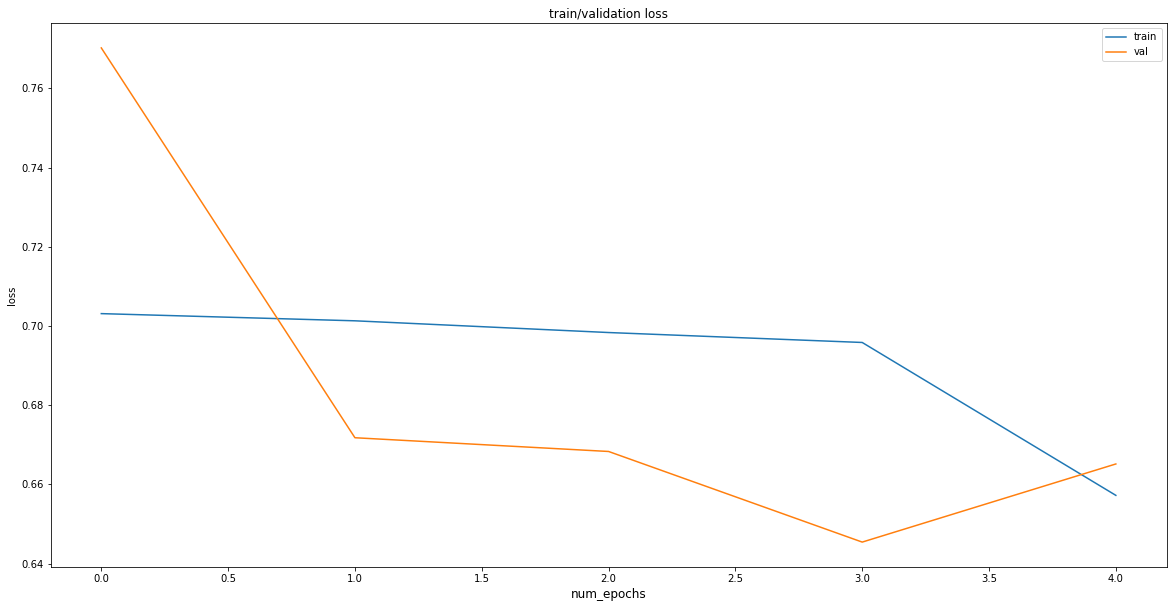

In [28]:
plot_statistics("loss", losses_pair)

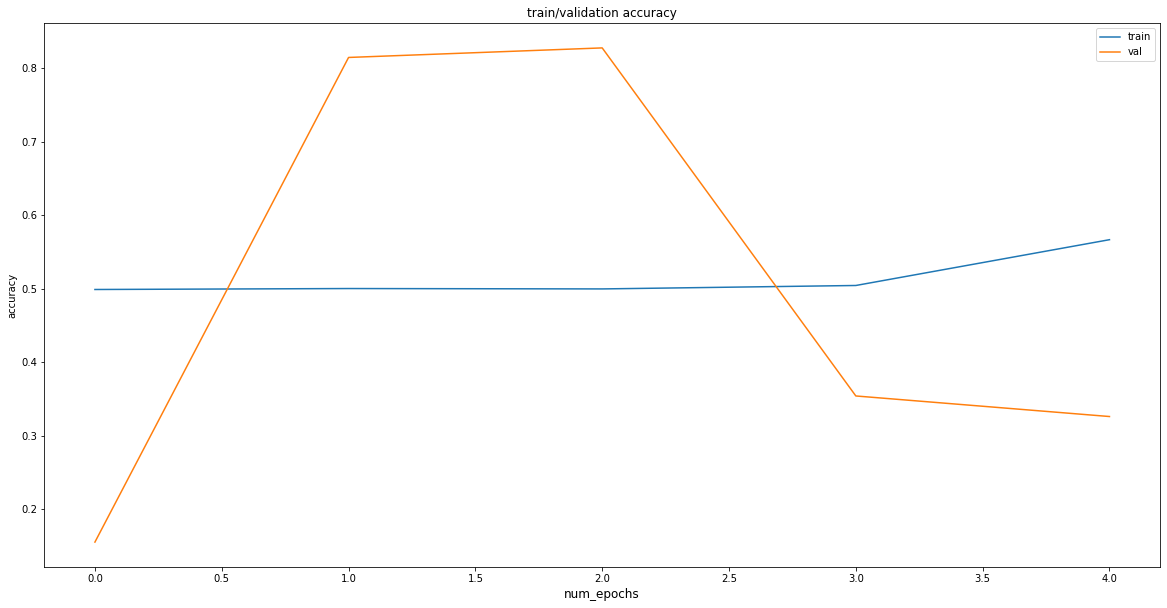

In [29]:
plot_statistics("accuracy", accuracies_pair)

In [30]:
# doc = train_set[647]

# doc

In [31]:
# predict(doc, device, model_fsent, model_pair, tokenizer)

In [32]:
# # predict first sentence position
# fsent_pos = predict_fsent_pos(doc, device, model_fsent, tokenizer)

# fsent_pos

In [33]:
# # predict sentence pairs logits
# pair_logits = predict_pair_logits(doc, device, model_pair, tokenizer)

# pair_logits

In [34]:
# # construct graph based on predictions
# num_vertices = len(doc['sentences'])
# graph = make_graph(num_vertices, pair_logits)

# graph.graph

In [35]:
# # sort and get the order
# order, weight = graph.max_flow(fsent_pos)

# order, weight

In [36]:
# index = [-1] * num_vertices
# for p, o in enumerate(order):
#     index[o] = p

# index

In [37]:
mean_val_corr = evaluate(val_set, device, model_fsent, model_pair, tokenizer, 1000)

mean_val_corr

  0%|          | 0/1000 [00:00<?, ?it/s]

0.3434857142857134

In [38]:
submission = predict_submission(pred_set, device, model_fsent, model_pair, tokenizer)

submission

  0%|          | 0/2000 [00:00<?, ?it/s]

,ID,index1,index2,index3,index4,index5,index6
0,1,5,1,2,3,4,0
1,2,5,2,3,0,4,1
2,3,1,3,2,0,5,4
3,4,5,0,4,3,2,1
4,5,3,1,4,0,2,5
...,...,...,...,...,...,...,...
1995,1996,0,1,4,3,2,5
1996,1997,4,2,1,3,0,5
1997,1998,4,2,5,1,0,3
1998,1999,4,1,2,5,3,0


In [39]:
submission.to_csv('submission.csv', index=False)